# Nami Tutorial

This tutorial introduces generative modeling with continuous normalising flows, covering both the mathematical foundations and practical implementation using the `nami` library.

## Table of Contents

1. [Introduction](#introduction)
2. [Flow Matching Basics](flow-matching-basics)
3. [Training a Flow Model](training-a-flow-model)
4. [Sampling](sampling)
5. [Diffusion Models](diffusion-models)
6. [Conditional Generation](conditional-generation)
7. [Likelihood Computation](likelihood-computation)
8. [Advanced Topics](advanced-topics)

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

torch.manual_seed(42)

import nami
import tutorial_utils as util
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


---
## Introduction

A generative model learns to create new samples that look like they came from a training dataset. Both flow matching and diffusion models share a key property:

> Generating samples = Transforming noise into data

Starting with samples from a simple distribution (like a Gaussian), one can then learn some transformation that converts them into samples from a target distribution (the data).


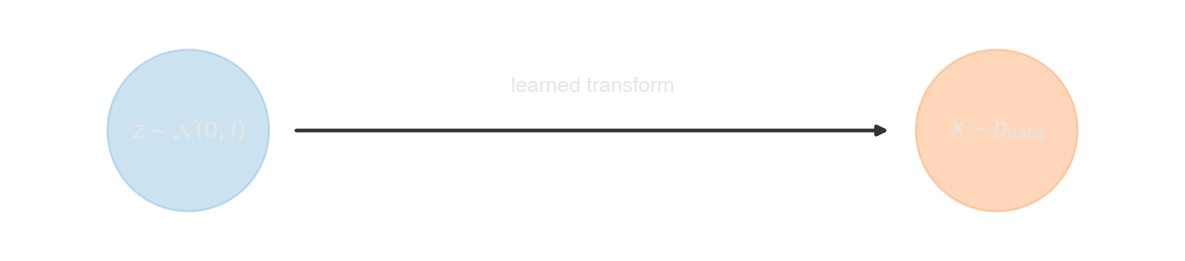

In [2]:
util._flow_diagram()

### Continuous vs discrete

The transformation can be discrete, i.e. a sequence of steps (like in VAEs or normalising flows with coupling layers) or Continuous, i.e. a smooth flow parameterized by time $t \in [0, 1]$. Flow matching and diffusion models use continuous transformations, defined by ordinary or stochastic differential equations.

---
## Flow Matching Basics

### Continuous normalising flows

Let $q_0$ denote a target (data) distribution on $\mathbb{R}^d$ and let $q_1$ denote a source (reference) distribution that is easy to sample, e.g. $q_1 = \mathcal{N}(0, I)$. A **continuous normalising flow** (CNF) is defined by a time-dependent velocity field $v_\theta : \mathbb{R}^d \times [0,1] \to \mathbb{R}^d$ whose integral curves push $q_1$ onto $q_0$. Concretely, we solve the ODE

$$\frac{d x_t}{d t} = v_\theta(x_t,\, t), \qquad x_1 \sim q_1,$$

and the terminal value $x_0$ is an approximate sample from $q_0$.

### Time convention

Throughout `nami` we adopt the convention $t=0 \;\Leftrightarrow\;$ data and $t=1 \;\Leftrightarrow\;$ noise. Sampling therefore integrates **backwards** from $t=1$ to $t=0$, while the forward (noising) direction runs from $t=0$ to $t=1$. This matches the convention used in Lipman et al. (2023) and Tong et al. (2024).

### Conditional flow matching objective

Direct regression onto the *marginal* velocity field $u_t(x)$ that generates $q_t$ is intractable because it requires knowledge of the full path of measures $(q_t)_{t \in [0,1]}$. The key insight of conditional flow matching is that one may instead regress onto conditional velocity fields $u_t(x \mid x_0)$, each of which generates a tractable conditional probability path $p_t(\cdot \mid x_0)$ that interpolates between a point mass at $x_0$ and the source $q_1$. Given a schedule of interpolation coefficients $(\alpha_t, \sigma_t)$ satisfying $\alpha_0 = 1,\; \sigma_0 = 0,\; \alpha_1 = 0,\; \sigma_1 = 1$, we form the conditional interpolant

$$x_t = \alpha_t \, x_0 + \sigma_t \, x_1, \qquad x_0 \sim q_0,\; x_1 \sim q_1,\; t \sim \mathcal{U}[0,1],$$

and the corresponding conditional velocity field is

$$u_t(x_t \mid x_0) = \dot{\alpha}_t \, x_0 + \dot{\sigma}_t \, x_1.$$

The conditional flow matching loss is then given by:

$$\mathcal{L}_{\text{CFM}}(\theta) = \mathbb{E}_{t,\, x_0,\, x_1} \bigl\lVert v_\theta(x_t,\, t) - u_t(x_t \mid x_0) \bigr\rVert^2.$$

Lipman et al. (2023) show that $\nabla_\theta \mathcal{L}_{\text{CFM}} = \nabla_\theta \mathcal{L}_{\text{FM}}$, so minimising the conditional objective recovers the correct marginal velocity field. For the linear (CondOT) schedule used by default in `nami`, $\alpha_t = 1 - t$ and $\sigma_t = t$, which gives

$$x_t = (1 - t)\, x_0 + t\, x_1, \qquad u_t = x_1 - x_0.$$

Okay, sometimes it's easier to visualise, so lets take a look at some interpolation paths...


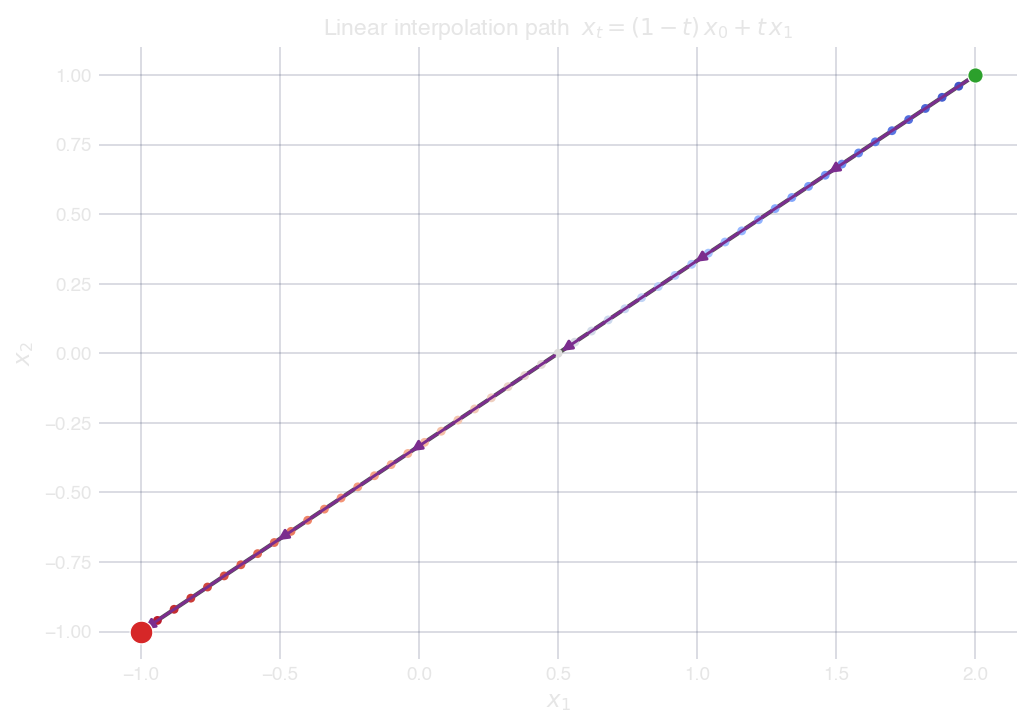

In [3]:
util._interpolation_path()


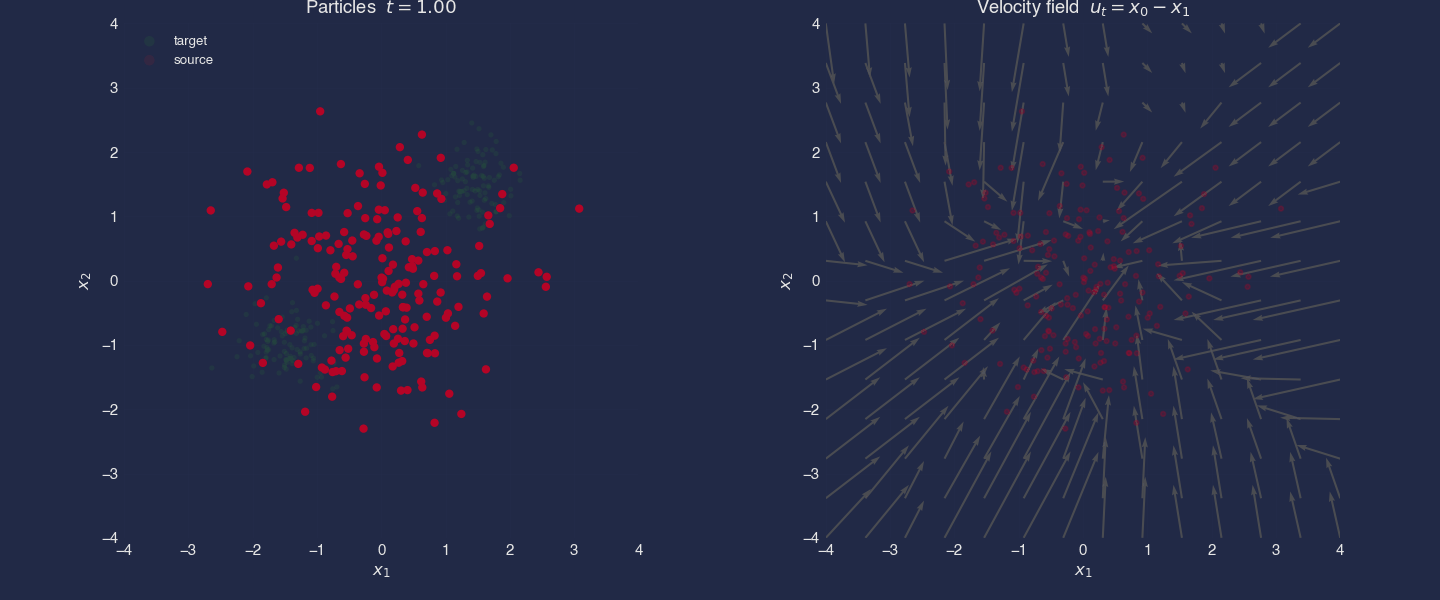

In [4]:
util._flow_field_gif()

---
## Training a Flow Model

Let's train a flow matching model on a simple 2D dataset: samples from a mixture of Gaussians.


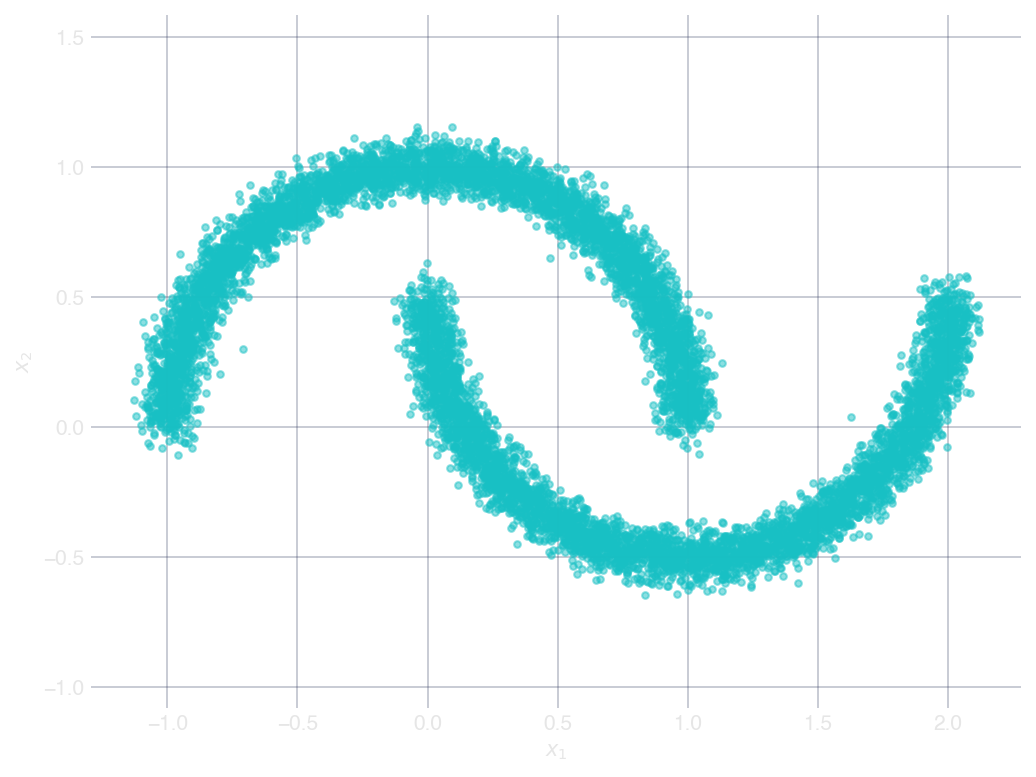

In [5]:
data = util.sample_moons(10000, noise=0.05)

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('equal')
plt.grid(True, alpha=0.3)
util._show_fig(fig)

### Define the velocity field network

The velocity field is a neural network that takes $(x, t)$ and outputs a velocity vector.

**Important**: The network must expose an `event_ndim` property telling nami how many dimensions form a single sample.

In [6]:
# Create the field
field = nami.VelocityField(dim=2, hidden=128).to(device)
print(f"Velocity field parameters: {sum(p.numel() for p in field.parameters()):,}")

Velocity field parameters: 25,410


### Training loop

We use `fm_loss` from nami, which handles the sampling random times $t \sim \text{Uniform}(0, 1)$, computing interpolated points $x_t$, computing target velocities $u_t$ and computing the  MSE/regression loss.

Epoch 500 | Loss: 1.0169
Epoch 1000 | Loss: 0.9765
Epoch 1500 | Loss: 0.9750
Epoch 2000 | Loss: 0.9487
Epoch 2500 | Loss: 0.9715
Epoch 3000 | Loss: 0.9474



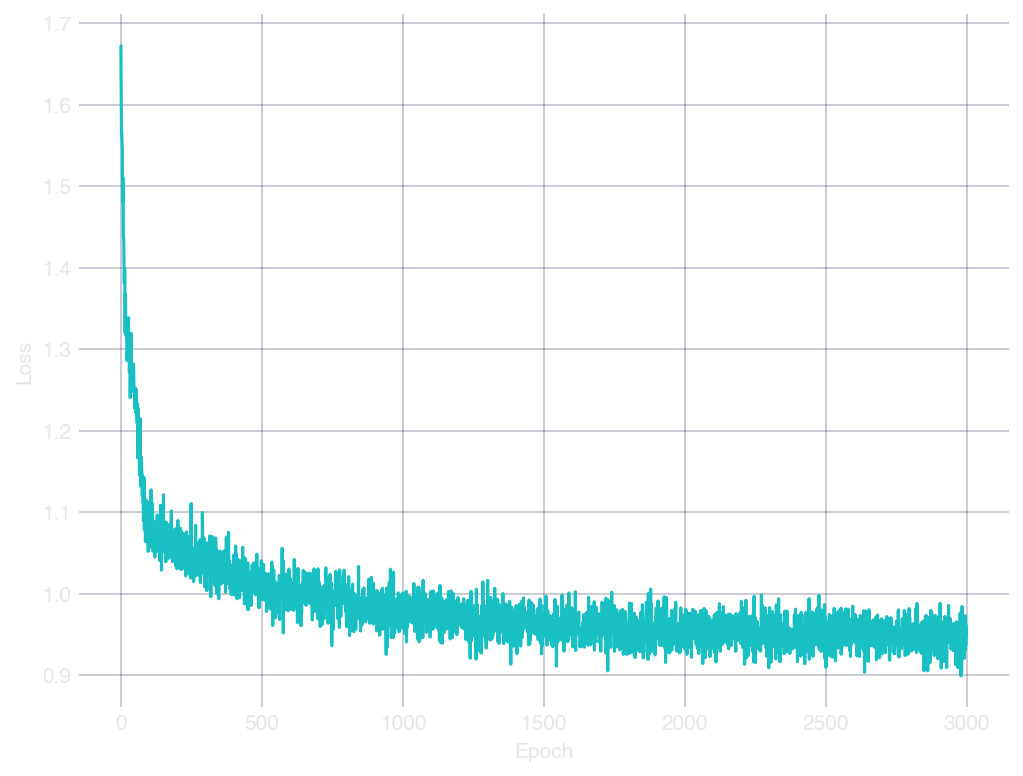

In [7]:
# training config
n_epochs = 3000
batch_size = 4096
lr = 1e-3

optimizer = torch.optim.Adam(field.parameters(), lr=lr)
losses = []

for epoch in range(n_epochs):
    # sample a batch of data
    idx = torch.randint(0, len(data), (batch_size,))
    x_target = data[idx].to(device)
    
    # sample from base distribution (standard Gaussian)
    x_source = torch.randn_like(x_target)
    
    # compute flow matching loss
    loss = nami.fm_loss(field, x_target, x_source)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f}")

# Plot training curve
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
util._show_fig(fig)

---
## Sampling

To generate samples, we sample from the base distribution (noise) and integrate the ODE from $t=1$ to $t=0$. Nami provides the `FlowMatching` class that wraps this process. By default, if no path is specified, the `LinearPath` is used.


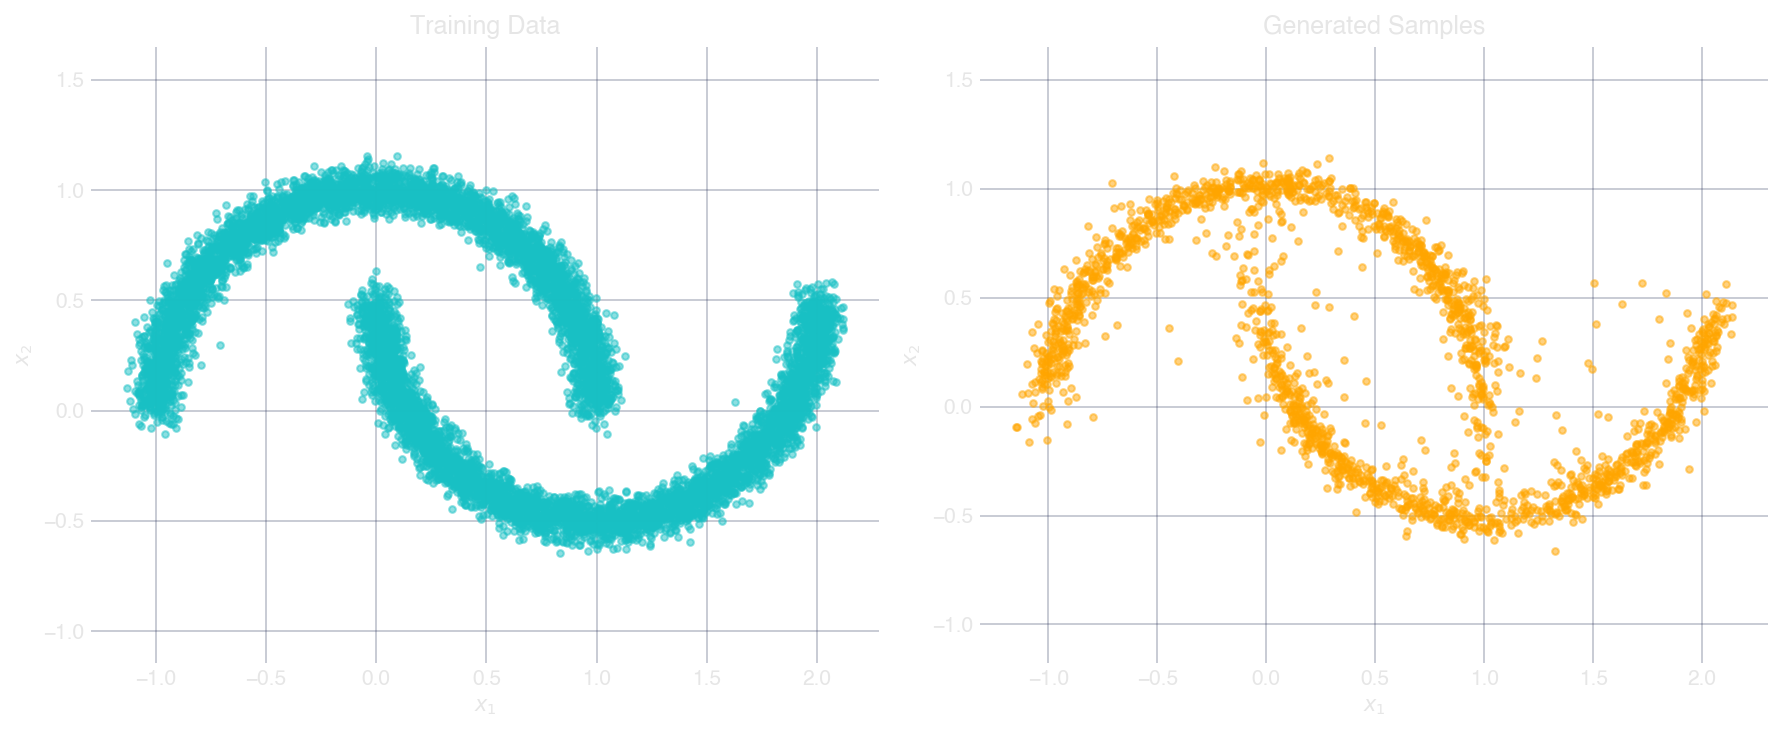

In [8]:
# Create the flow matching sampler
base = nami.StandardNormal(event_shape=(2,), device=device)
solver = nami.RK4(steps=100)  # 4th-order Runge-Kutta with 100 steps

fm = nami.FlowMatching(
    field=field,
    base=base,
    solver=solver,
    t0=1.0,  # start at noise
    t1=0.0,  # end at data
)

# bind (no conditioning in this example)
process = fm(None)

with torch.no_grad():
    samples = process.sample((2000,))

samples = samples.cpu()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(data[:, 0], data[:, 1], alpha=0.5, s=10, label='Real data')
axes[0].set_title('Training Data')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10, c='orange', label='Generated')
axes[1].set_title('Generated Samples')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
util._show_fig(fig)

### Visualising the flow

Let's watch how samples evolve from noise to data:


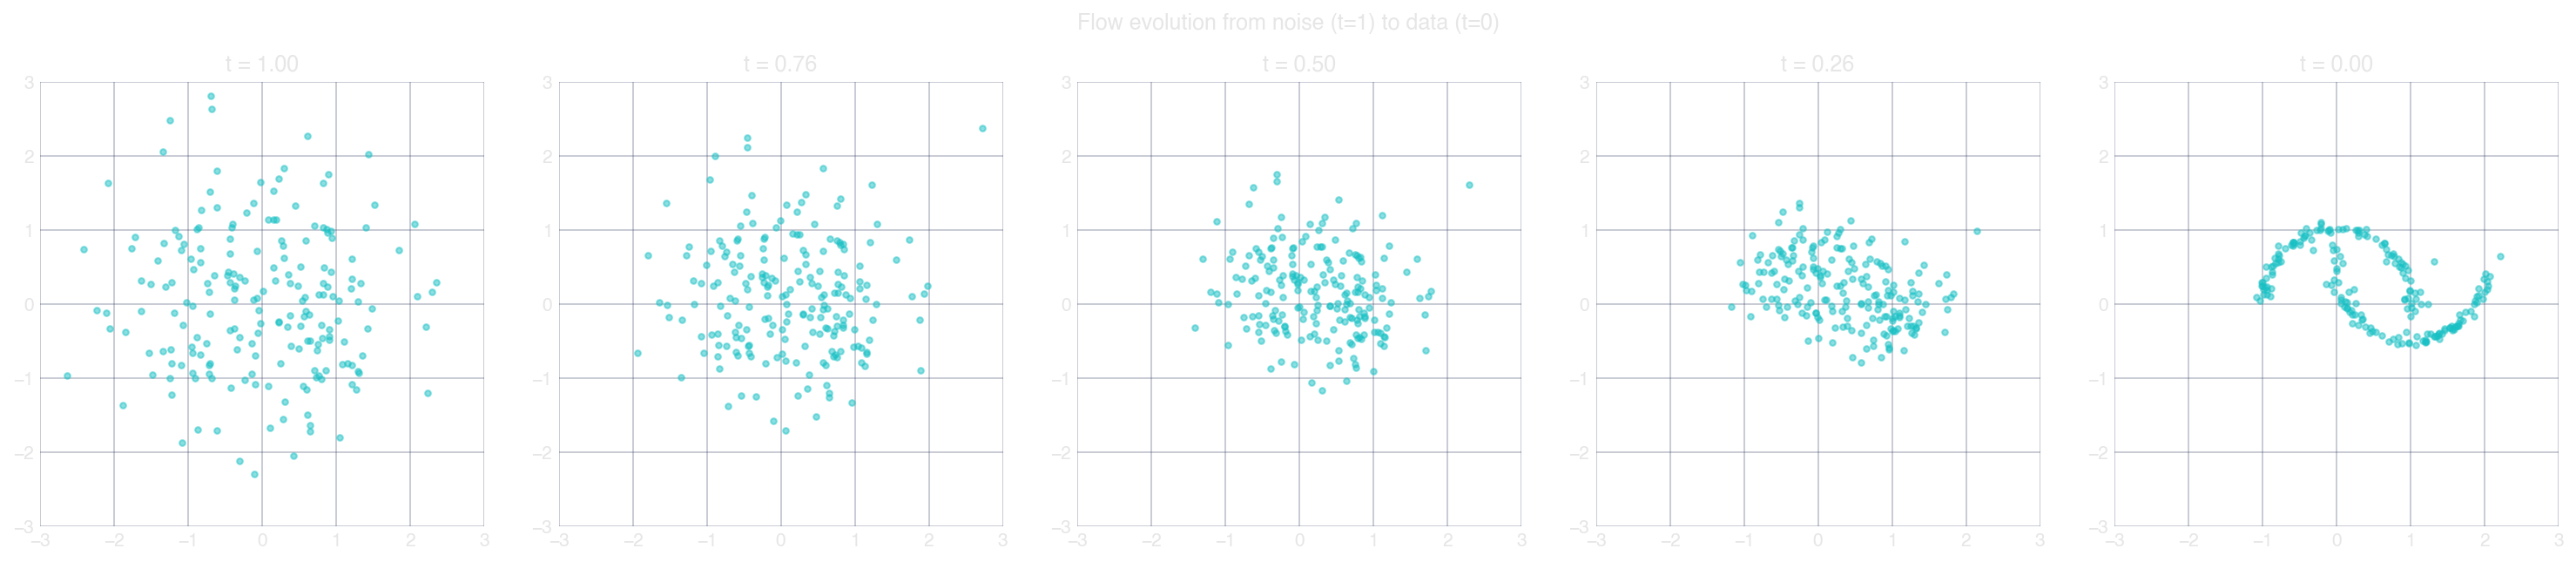

In [9]:
def sample_trajectory(field, n_samples, n_steps=50):
    """Sample and record the full trajectory from noise to data."""
    
    # start from noise
    x = torch.randn(n_samples, 2, device=device)
    trajectory = [x.cpu().clone()]
    
    # integrate from t=1 to t=0
    dt = -1.0 / n_steps
    t = 1.0
    
    with torch.no_grad():
        for _ in range(n_steps):
            t_tensor = torch.full((n_samples,), t, device=device)
            v = field(x, t_tensor)
            x = x + v * dt
            t = t + dt
            trajectory.append(x.cpu().clone())
    
    return torch.stack(trajectory)  # (n_steps+1, n_samples, 2)

trajectories = sample_trajectory(field, n_samples=200, n_steps=50)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
times_to_show = [0, 12, 25, 37, 50]  # these are indices corresponding to t=1, 0.75, 0.5, 0.25, 0

for ax, idx in zip(axes, times_to_show):
    t_val = 1.0 - idx / 50
    points = trajectories[idx]
    ax.scatter(points[:, 0], points[:, 1], alpha=0.5, s=10)
    ax.set_title(f't = {t_val:.2f}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.suptitle('Flow evolution from noise (t=1) to data (t=0)', y=1.02)
plt.tight_layout()
util._show_fig(fig)


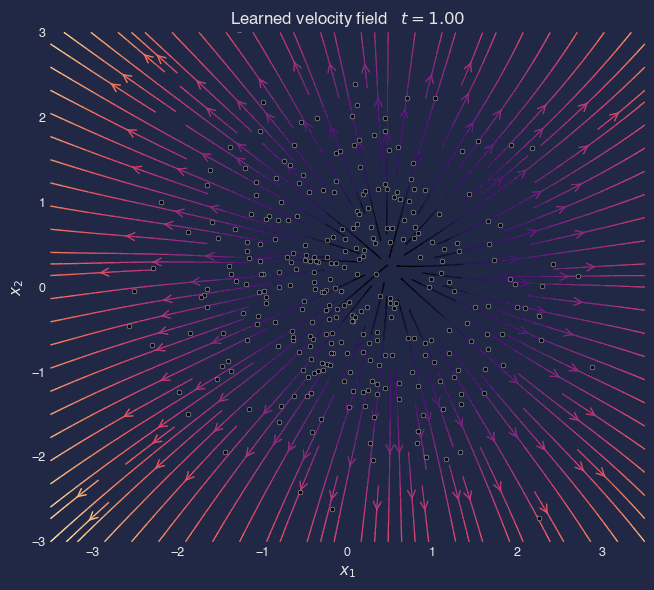

In [10]:
util._learned_flow_gif(field, device)

---
## Diffusion Models

### The forward (noising) process

Whereas flow matching directly learns a velocity field that transports a reference measure onto the data, diffusion models take a complementary view: they first define a fixed **forward process** that continuously corrupts data into noise, and then learn to reverse it. Given a data point $x_0 \sim q_0$ and independent noise $\epsilon \sim \mathcal{N}(0, I)$, the forward process produces a noisy sample at time $t \in [0, 1]$ via

$$x_t = \alpha(t)\, x_0 + \sigma(t)\, \epsilon,$$

where the noise schedule $(\alpha, \sigma)$ satisfies the boundary conditions $\alpha(0) = 1,\; \sigma(0) = 0$ (clean data) and $\alpha(1) \approx 0,\; \sigma(1) \approx 1$ (approximately pure noise). The conditional distribution is therefore Gaussian:

$$q_{t \mid 0}(x_t \mid x_0) = \mathcal{N}\!\bigl(x_t;\; \alpha(t)\, x_0,\; \sigma(t)^2 I\bigr).$$

This process can equivalently be written as an Ito SDE. For a general schedule define the drift and diffusion coefficient

$$f(t) = \frac{\dot{\alpha}(t)}{\alpha(t)}, \qquad g(t)^2 = \dot{\sigma}(t)^2 - 2\,f(t)\,\sigma(t)^2,$$

so that $dx_t = f(t)\,x_t\,dt + g(t)\,dW_t$, where $W_t$ is a standard Wiener process. This SDE perspective is important because it gives us access to the reverse-time SDE (Anderson, 1982) used for sampling.

### Noise schedules

The choice of $\alpha(t)$ and $\sigma(t)$ defines a *family* of diffusion models. Three basic and (perhaps not these days as much) widely-used schedules are:

| Schedule | Signal coefficient $\alpha(t)$ | Noise coefficient $\sigma(t)$ | Key property |
|----------|-------------------------------|-------------------------------|-------------|
| **VP** (Ho et al., 2020) | $\sqrt{\bar{\alpha}(t)}$ | $\sqrt{1 - \bar{\alpha}(t)}$ | $\alpha^2 + \sigma^2 = 1$ (variance preserving) |
| **VE** (Song et al., 2021) | $1$ | $\sigma_{\min}\bigl(\sigma_{\max}/\sigma_{\min}\bigr)^t$ | $\alpha = 1$; variance explodes with $t$ |
| **EDM** (Karras et al., 2022) | $1$ | $t$ (or learned) | Re-parameterised for optimal sampling; preconditioned network |

In `nami` these are available as `VPSchedule`, `VESchedule`, and `EDMSchedule` respectively. Each schedule object exposes `alpha(t)` and `sigma(t)` (and their derivatives) so that the same training and sampling code works across all three.

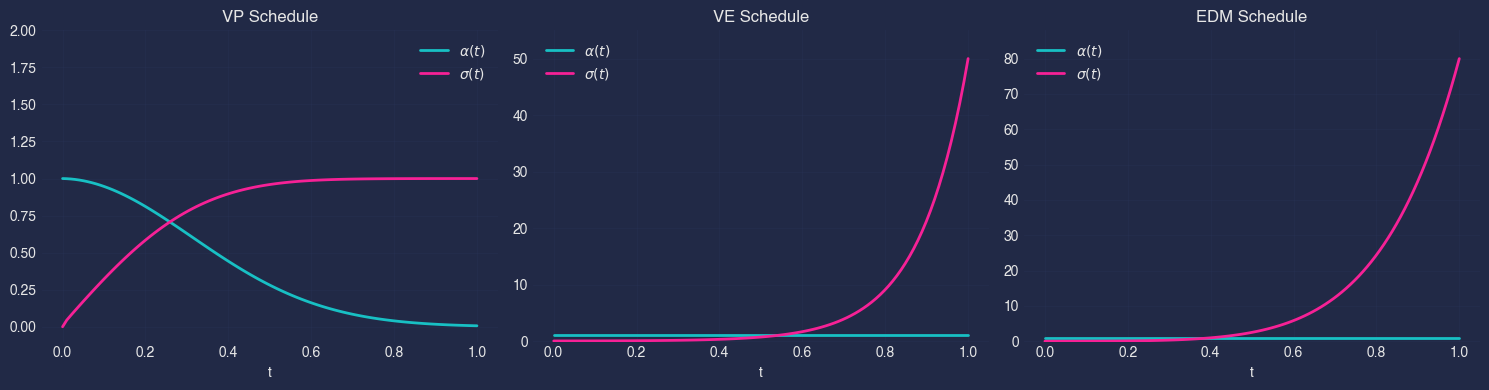

In [11]:
t = torch.linspace(0, 1, 100)

schedules = {
    'VP': nami.VPSchedule(beta_min=0.1, beta_max=20.0),
    'VE': nami.VESchedule(sigma_min=0.01, sigma_max=50.0),
    'EDM': nami.EDMSchedule(sigma_min=0.002, sigma_max=80.0),
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, schedule) in zip(axes, schedules.items()):
    alpha = schedule.alpha(t).numpy()
    sigma = schedule.sigma(t).numpy()
    
    ax.plot(t.numpy(), alpha, label=r'$\alpha(t)$', linewidth=2)
    ax.plot(t.numpy(), sigma, label=r'$\sigma(t)$', linewidth=2)
    ax.set_xlabel('t')
    ax.set_title(f'{name} Schedule')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, max(2, sigma.max() * 1.1))

plt.tight_layout()
plt.show()

### The reverse process

To generate samples we run the forward SDE **backwards in time**. By Anderson (1982), the reverse-time SDE reads

$$dx_t = \bigl[f(t)\,x_t - g(t)^2\,\nabla_{x_t} \log q_t(x_t)\bigr]\,dt + g(t)\,d\bar{W}_t,$$

where $\bar{W}_t$ is a reverse-time Wiener process and $\nabla_x \log q_t(x)$ is the score function of the marginal $q_t$. Setting the diffusion to zero yields the deterministic probability-flow ODE

$$dx_t = \biggl[f(t)\,x_t - \tfrac{1}{2}\,g(t)^2\,\nabla_{x_t} \log q_t(x_t)\biggr]\,dt,$$

which generates the same marginals $q_t$ but without stochasticity.

### Parameterisation equivalences

The score is the only unknown quantity, and it can be learned under several equivalent parameterisations. Given a neural network $D_\theta$ we can predict:

| Parameterisation | Network target | Relation to score |
|---|---|---|
| **Score** ($s$-prediction) | $s_\theta(x_t, t) \approx \nabla_x \log q_t(x_t)$ | identity |
| **Noise** ($\epsilon$-prediction) | $\hat\epsilon_\theta(x_t, t) \approx \epsilon$ | $\nabla_x \log q_t = -\hat\epsilon / \sigma(t)$ |
| **Data** ($x_0$-prediction) | $\hat x_{0,\theta}(x_t, t) \approx x_0$ | $\nabla_x \log q_t = \bigl(\alpha(t)\,\hat x_0 - x_t\bigr) / \sigma(t)^2$ |
| **Velocity** ($v$-prediction) | $v_\theta(x_t, t) \approx \dot\alpha(t)\,x_0 + \dot\sigma(t)\,\epsilon$ | converts to score via schedule |

These are algebraically interchangeable: `nami` wraps each in a unified interface so you can train with one parameterisation and sample with any solver.

### Training objective

Regardless of parameterisation, the denoising score matching loss (Vincent, 2011) reduces to

$$\mathcal{L}_{\text{DSM}}(\theta) = \mathbb{E}_{t \sim \mathcal{U}[0,1],\; x_0 \sim q_0,\; \epsilon \sim \mathcal{N}(0,I)} \bigl[\lambda(t)\,\lVert D_\theta(x_t, t) - \text{target} \rVert^2\bigr],$$

where $\lambda(t)$ is an optional weighting function (e.g. SNR-based for EDM). This is directly analogous to the CFM loss from the flow matching section — both regress a network onto a conditional quantity that, in expectation, recovers the correct marginal field.

> [!IMPORTANT] put diffusion training logic into package instead of the manual approach here.

Epoch 500 | Loss: 0.6276
Epoch 1000 | Loss: 0.6057
Epoch 1500 | Loss: 0.5849
Epoch 2000 | Loss: 0.5719
Epoch 2500 | Loss: 0.5667
Epoch 3000 | Loss: 0.5687



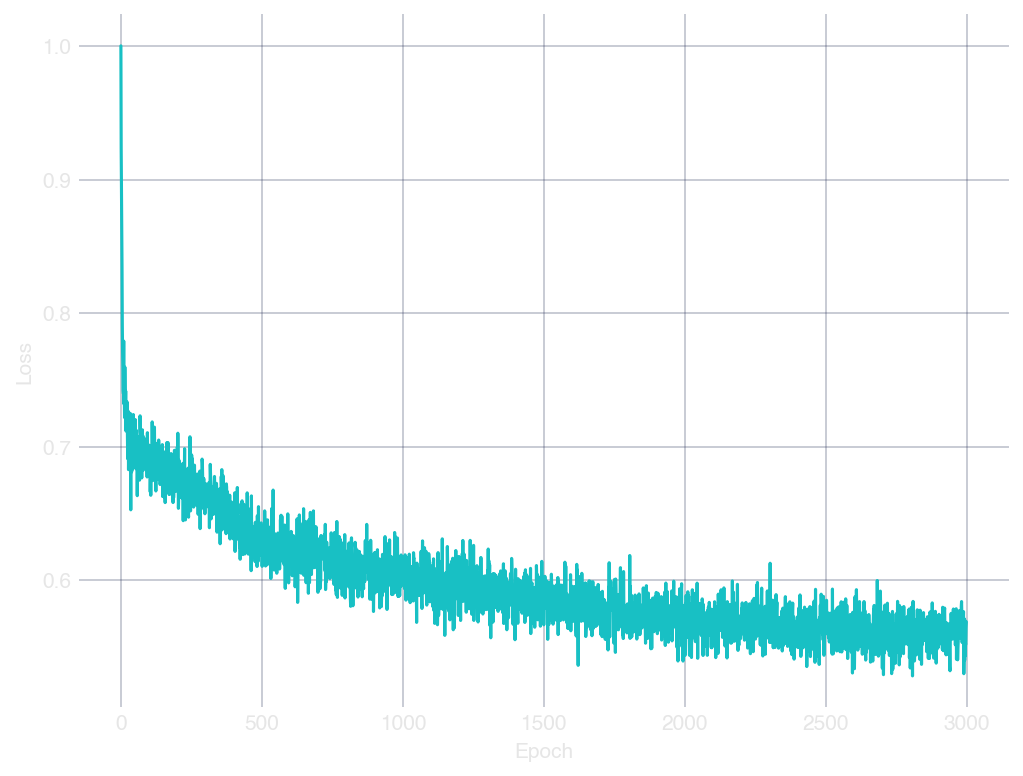

In [12]:
# training config
n_epochs = 3000
batch_size = 4096
lr = 1e-3

# for diffusion, we typically predict the noise (eps parameterisation)
class NoisePredictor(nn.Module):
    """Predicts the noise that was added to create x_t."""
    def __init__(self, dim: int = 2, hidden: int = 256):
        super().__init__()
        self.dim = dim
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, dim),
        )
    
    @property
    def event_ndim(self) -> int:
        return 1
    
    def forward(self, x: torch.Tensor, t: torch.Tensor, c=None) -> torch.Tensor:
        t_expanded = t.unsqueeze(-1).expand(*x.shape[:-1], 1)
        inputs = torch.cat([x, t_expanded], dim=-1)
        return self.net(inputs)

# create and train
eps_model = NoisePredictor(dim=2, hidden=128).to(device)
schedule = nami.EDMSchedule(sigma_min=0.001, sigma_max=5.0)
optimizer = torch.optim.Adam(eps_model.parameters(), lr=1e-3)

losses = []
for epoch in range(n_epochs):
    idx = torch.randint(0, len(data), (batch_size,))
    x0 = data[idx].to(device)
    
    t = torch.rand(batch_size, device=device)
    eps = torch.randn_like(x0)
    
    # create noisy samples: x_t = alpha(t) * x0 + sigma(t) * eps
    alpha = schedule.alpha(t).unsqueeze(-1)
    sigma = schedule.sigma(t).unsqueeze(-1)
    x_t = alpha * x0 + sigma * eps
    
    # predict noise
    eps_pred = eps_model(x_t, t)
    loss = (eps_pred - eps).pow(2).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f}")

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
util._show_fig(fig)

### Sampling from diffusion models

Given a trained network $D_\theta$, `nami` supports two sampling strategies. ODE sampling (deterministic) integrates the probability-flow ODE from $t=1$ to $t=0$ using any ODE solver (`RK4`, `Heun`, etc.). This is deterministic for a given initial noise sample and permits exact likelihood evaluation via the instantaneous change-of-variables formula. SDE sampling (stochastic) integrates the reverse-time SDE using a stochastic solver, such as `EulerMaruyama`. The injected noise during sampling can improve sample quality by correcting accumulated discretisation error, at the cost of requiring more steps for convergence. In `nami` both modes use the same `Diffusion` class, where the choice of solver determines which path is taken.


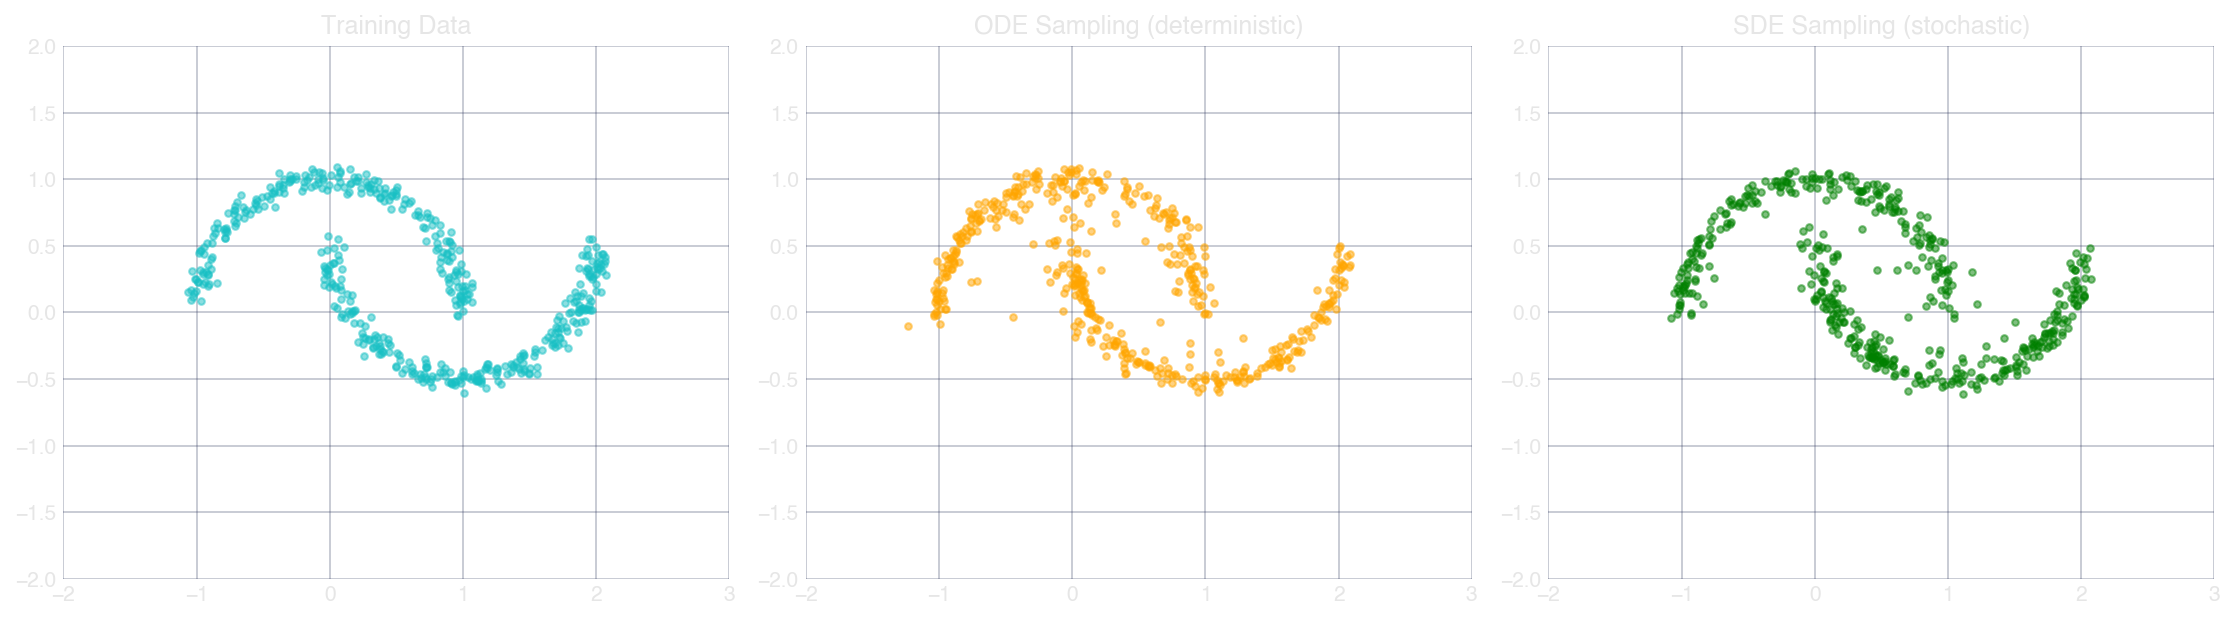

In [13]:
# create diffusion sampler with ODE solver
# NOTE: We use t1=1e-3 instead of 0 to avoid numerical instability
# (sigma(0)=0 causes division by zero in score computation)
diffusion_ode = nami.Diffusion(
    model=eps_model,
    schedule=schedule,
    solver=nami.RK4(steps=500),
    parameterization="eps",
    event_shape=(2,),
    t1=1e-3,  # stop slightly before t=0 to avoid sigma=0
)

# create diffusion sampler with SDE solver
diffusion_sde = nami.Diffusion(
    model=eps_model,
    schedule=schedule,
    solver=nami.EulerMaruyama(steps=500),
    parameterization="eps",
    event_shape=(2,),
    t1=1e-3,
)

# generate samples
with torch.no_grad():
    samples_ode = diffusion_ode(None).sample((500,)).cpu()
    samples_sde = diffusion_sde(None).sample((500,)).cpu()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(data[:500, 0], data[:500, 1], alpha=0.5, s=10)
axes[0].set_title('Training Data')

axes[1].scatter(samples_ode[:, 0], samples_ode[:, 1], alpha=0.5, s=10, c='orange')
axes[1].set_title('ODE Sampling (deterministic)')

axes[2].scatter(samples_sde[:, 0], samples_sde[:, 1], alpha=0.5, s=10, c='green')
axes[2].set_title('SDE Sampling (stochastic)')

for ax in axes:
    ax.set_xlim(-2, 3)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
util._show_fig(fig)

---
## Conditional Generation

Both flow matching and diffusion support conditional generation where samples are guided by some context $c$. Some examples of this include class-conditional image generation (c = class label), text-to-image (c = text embedding) and inpainting (c = partial image) or partial diffusion. Nami uses a "lazy binding" pattern, where we define the model once: `fm = FlowMatching(field, base, solver)` then bind context when needed like `process = fm(context)`. To sample, one then does `samples = process.sample((n,))` which cleanly separates model definition from conditional execution.


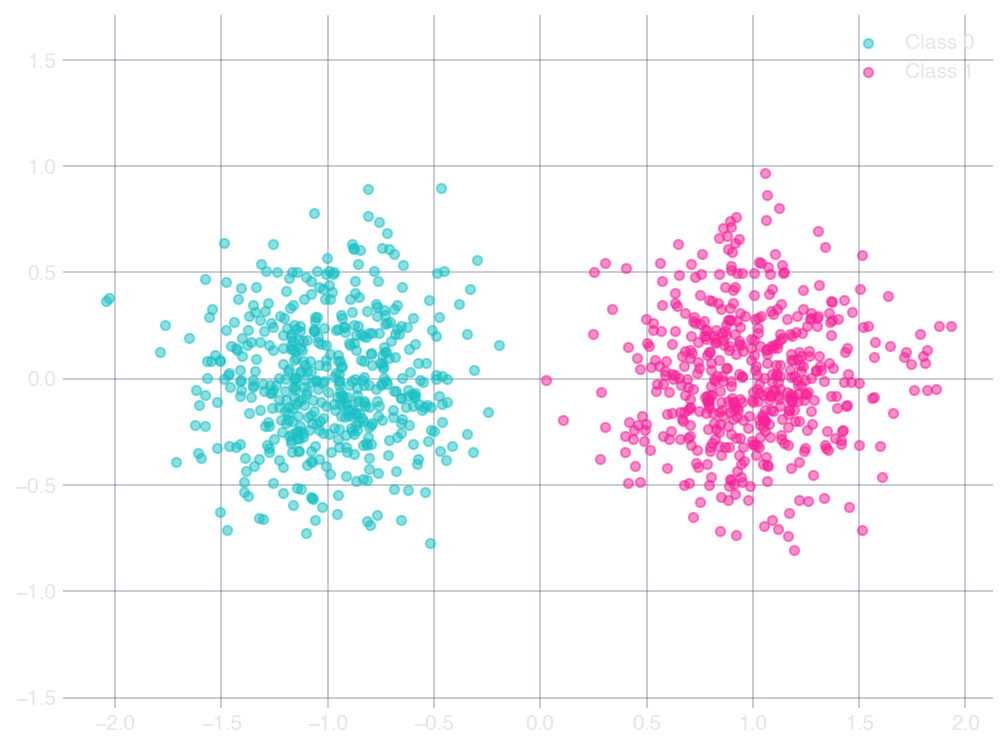

In [14]:
# generate class-conditional data: two clusters with labels
def sample_conditional_data(n_samples):
    """Generate data from two Gaussian clusters with class labels."""
    n_per_class = n_samples // 2
    
    # [0]: cluster at (-1, 0)
    x0 = torch.randn(n_per_class, 2) * 0.3 + torch.tensor([-1.0, 0.0])
    c0 = torch.zeros(n_per_class, 1)  # context: class 0
    
    # [1]: cluster at (1, 0)
    x1 = torch.randn(n_per_class, 2) * 0.3 + torch.tensor([1.0, 0.0])
    c1 = torch.ones(n_per_class, 1)   # context: class 1
    
    x = torch.cat([x0, x1], dim=0)
    c = torch.cat([c0, c1], dim=0)
    
    # shuffle
    perm = torch.randperm(len(x))
    return x[perm], c[perm]

x_data, c_data = sample_conditional_data(1000)

fig, ax = plt.subplots(figsize=(8, 6))
mask0 = c_data[:, 0] == 0
mask1 = c_data[:, 0] == 1
plt.scatter(x_data[mask0, 0], x_data[mask0, 1], alpha=0.5, s=20, label='Class 0')
plt.scatter(x_data[mask1, 0], x_data[mask1, 1], alpha=0.5, s=20, label='Class 1')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
util._show_fig(fig)

In [15]:
class ConditionalVelocityField(nn.Module):
    def __init__(self, dim: int = 2, context_dim: int = 1, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + context_dim + 1, hidden),  # x + c + t
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, dim),
        )
    
    @property
    def event_ndim(self) -> int:
        return 1
    
    def forward(self, x: torch.Tensor, t: torch.Tensor, c: torch.Tensor = None) -> torch.Tensor:
        t_expanded = t.unsqueeze(-1).expand(*x.shape[:-1], 1)
        inputs = torch.cat([x, t_expanded, c], dim=-1)
        return self.net(inputs)

# train conditional model
cond_field = ConditionalVelocityField(dim=2, context_dim=1, hidden=128).to(device)
optimizer = torch.optim.Adam(cond_field.parameters(), lr=1e-3)

for epoch in range(n_epochs):
    idx = torch.randint(0, len(x_data), (batch_size,))
    x_target = x_data[idx].to(device)
    c = c_data[idx].to(device)
    x_source = torch.randn_like(x_target)
    
    # fm_loss accepts the context
    loss = nami.fm_loss(cond_field, x_target, x_source, c=c)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f}")

print("Training complete!")

Epoch 500 | Loss: 0.5201
Epoch 1000 | Loss: 0.5102
Epoch 1500 | Loss: 0.5003
Epoch 2000 | Loss: 0.4779
Epoch 2500 | Loss: 0.4828
Epoch 3000 | Loss: 0.4911
Training complete!



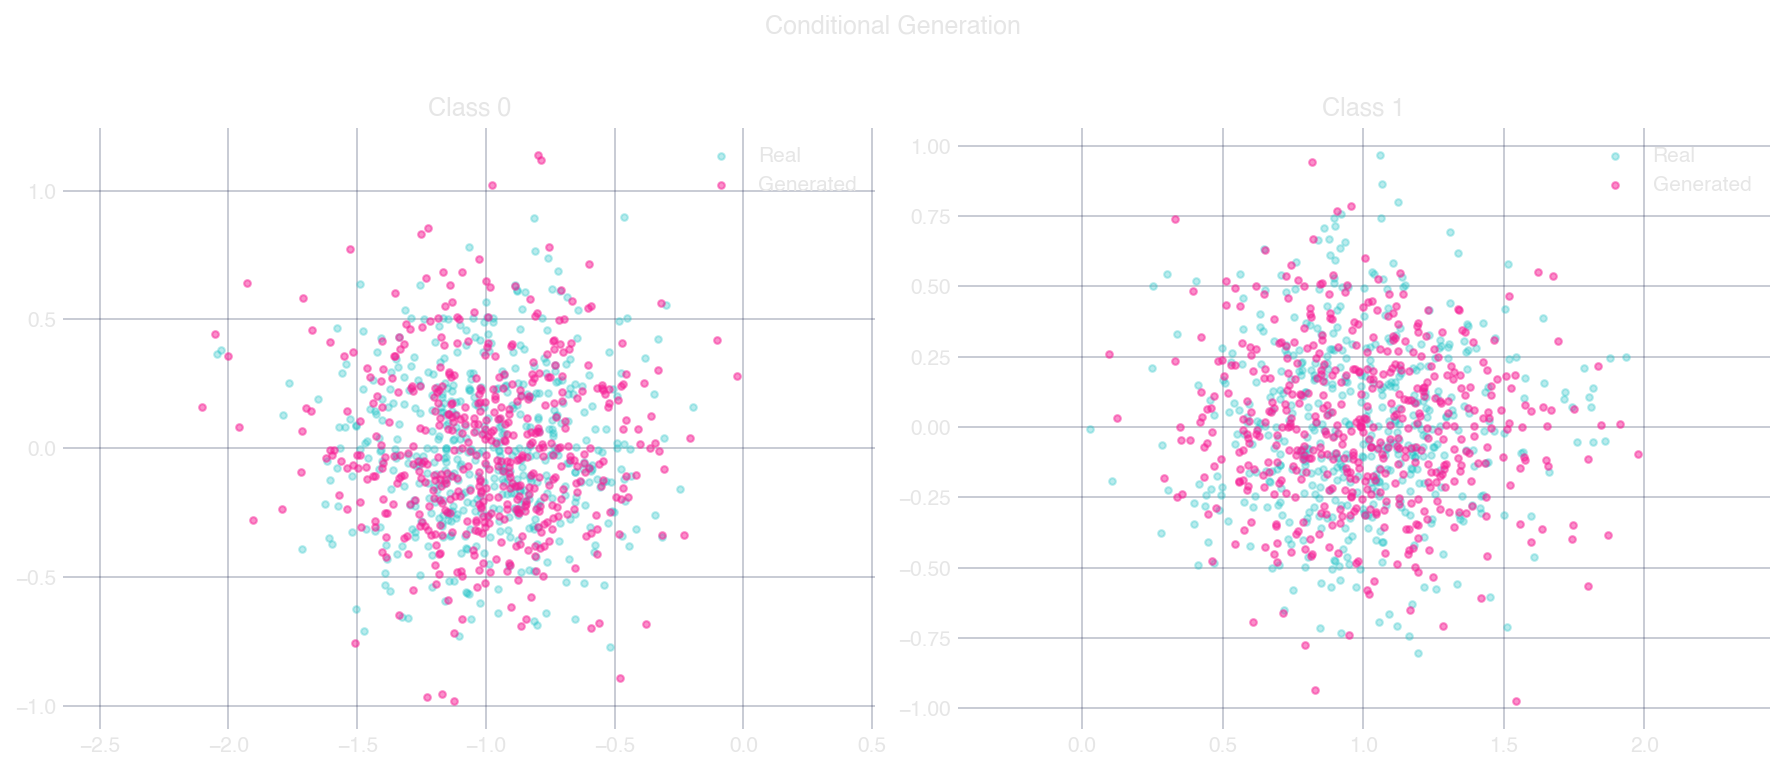

In [16]:
# Conditional sampling
base = nami.StandardNormal(event_shape=(2,), device=device)
solver = nami.RK4(steps=50)

cond_fm = nami.FlowMatching(
    field=cond_field,
    base=base,
    solver=solver,
)

n_samples = 500

context_0 = torch.zeros(n_samples, 1, device=device)
process_0 = cond_fm(context_0)  # Bind context
with torch.no_grad():
    samples_0 = process_0.sample((1,)).squeeze(0).cpu()  # (1, 500, 2) -> (500, 2)

context_1 = torch.ones(n_samples, 1, device=device)
process_1 = cond_fm(context_1)
with torch.no_grad():
    samples_1 = process_1.sample((1,)).squeeze(0).cpu()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(x_data[mask0, 0], x_data[mask0, 1], alpha=0.3, s=10, label='Real')
axes[0].scatter(samples_0[:, 0], samples_0[:, 1], alpha=0.5, s=10, label='Generated')
axes[0].set_title('Class 0')
axes[0].legend()
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(x_data[mask1, 0], x_data[mask1, 1], alpha=0.3, s=10, label='Real')
axes[1].scatter(samples_1[:, 0], samples_1[:, 1], alpha=0.5, s=10, label='Generated')
axes[1].set_title('Class 1')
axes[1].legend()
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Conditional Generation', y=1.02)
plt.tight_layout()
util._show_fig(fig)

---
## Likelihood Computation

Although flow matching models are not trained by maximum likelihood, the instantaneous change of variables formula still allows us to evaluate the log-density implied by the learned flow. This is the density of the pushforward measure induced by $v_\theta$, and equals the true data log-density only to the extent that $v_\theta$ accurately approximates the target velocity field. The resulting log-likelihoods are therefore useful for model comparison, density estimation, and diagnostics, but should be understood as properties of the learned model rather than exact evaluations of $\log q_0$.

### Instantaneous change of variables

Let $\phi_t : \mathbb{R}^d \to \mathbb{R}^d$ denote the flow map induced by the velocity field $v_\theta$, i.e. $\frac{d}{dt}\phi_t(x) = v_\theta(\phi_t(x), t)$ with $\phi_0(x) = x$. For a base density $q_1$ (e.g. $\mathcal{N}(0, I)$), the model density at $t = 0$ is given by the instantaneous change of variables formula (Chen et al., 2018):

$$\log q_0(x) = \log q_1\!\bigl(\phi_1(x)\bigr) + \int_0^1 \operatorname{tr}\!\Bigl(\frac{\partial v_\theta}{\partial x}\bigl(\phi_t(x),\, t\bigr)\Bigr)\, dt,$$

where $\operatorname{tr}\!\bigl(\frac{\partial v_\theta}{\partial x}\bigr) = \nabla \cdot v_\theta = \sum_{i=1}^{d} \frac{\partial [v_\theta]_i}{\partial x_i}$ is the divergence of the velocity field. In practice this is evaluated by solving an augmented ODE that jointly integrates the trajectory $\phi_t(x)$ and the cumulative log-determinant.

### Computing the divergence

The divergence $\nabla \cdot v_\theta$ requires the diagonal of the Jacobian $\frac{\partial v_\theta}{\partial x} \in \mathbb{R}^{d \times d}$. Two strategies are available. Exact trace where each diagonal entry $\frac{\partial [v_\theta]_i}{\partial x_i}$ is computed via $d$ backward passes (or a single forward-mode AD pass). This is tractable only when $d$ is small. In `nami` this is provided by `ExactDivergence`. Hutchinson estimator (Hutchinson, 1990) where the trace is approximated stochastically:

$$\nabla \cdot v_\theta(x, t) = \mathbb{E}_{\epsilon}\bigl[\epsilon^\top \tfrac{\partial v_\theta}{\partial x} \,\epsilon\bigr], \qquad \epsilon \sim \mathcal{N}(0, I) \;\text{or}\; \text{Rademacher},$$

which requires only a single vector-Jacobian product per sample of $\epsilon$ — an $O(d)$ operation via reverse-mode AD. The estimator is unbiased with variance that decreases as more projections are averaged. In `nami` this is provided by `HutchinsonDivergence`. For low-dimensional problems (e.g. the 2D examples in this tutorial), exact divergence is cheap and preferable. For high-dimensional data (images, point clouds), the Hutchinson estimator is essential.

In [17]:
# for likelihood, we need the field to support divergence computation

# use our trained flow matching model
process = fm(None)

# compute log-likelihood of some test points
test_points = data[:100].to(device)

# using Hutchinson estimator (stochastic but scalable)
estimator = nami.HutchinsonDivergence(probe="rademacher")

with torch.no_grad():
    # > Note: log_prob integrates from data (t=0) to noise (t=1)
    log_probs = process.log_prob(test_points, estimator=estimator)

print(f"Log-likelihood statistics:")
print(f"  Mean: {log_probs.mean().item():.2f}")
print(f"  Std:  {log_probs.std().item():.2f}")
print(f"  Min:  {log_probs.min().item():.2f}")
print(f"  Max:  {log_probs.max().item():.2f}")

Log-likelihood statistics:
  Mean: -5.01
  Std:  1.68
  Min:  -8.89
  Max:  -1.78



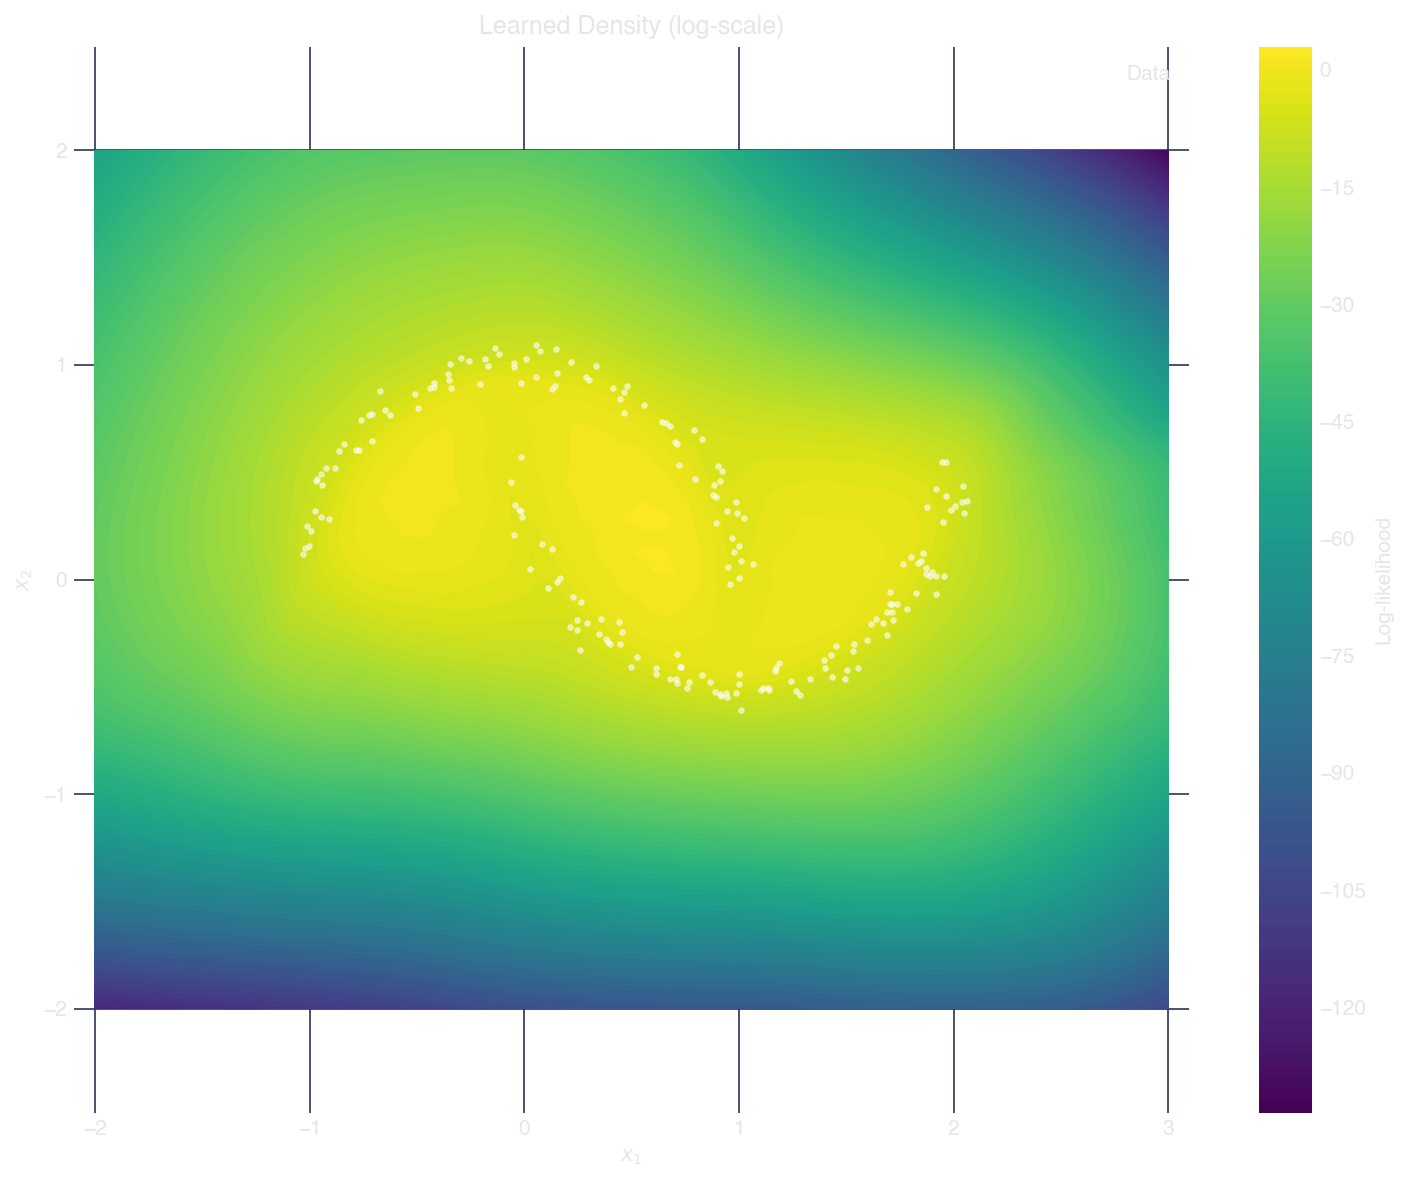

In [18]:
n_grid = 50
x_range = torch.linspace(-2, 3, n_grid)
y_range = torch.linspace(-2, 2, n_grid)
xx, yy = torch.meshgrid(x_range, y_range, indexing='xy')
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

# compute log-probs (this may take a moment)
with torch.no_grad():
    log_probs_grid = process.log_prob(grid_points, estimator=estimator)

log_probs_grid = log_probs_grid.cpu().reshape(n_grid, n_grid)


fig, ax = plt.subplots(figsize=(10, 8))
plt.contourf(xx.numpy(), yy.numpy(), log_probs_grid.numpy(), levels=100, cmap='viridis')
plt.colorbar(label='Log-likelihood')
plt.scatter(data[:200, 0], data[:200, 1], c='white', s=5, alpha=0.5, label='Data')
plt.title('Learned Density (log-scale)')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.axis('equal')
plt.tight_layout()
util._show_fig(fig)

---
## Extra topics

### Solver choices

The choice of ODE solver affects both speed and quality. A simple example is given below for the RK4 method.

| Solver | Steps | Quality | Speed |
|--------|-------|---------|-------|
| RK4(steps=10) | 10 | Lower | Fast |
| RK4(steps=50) | 50 | Good | Medium |
| RK4(steps=100) | 100 | High | Slow |


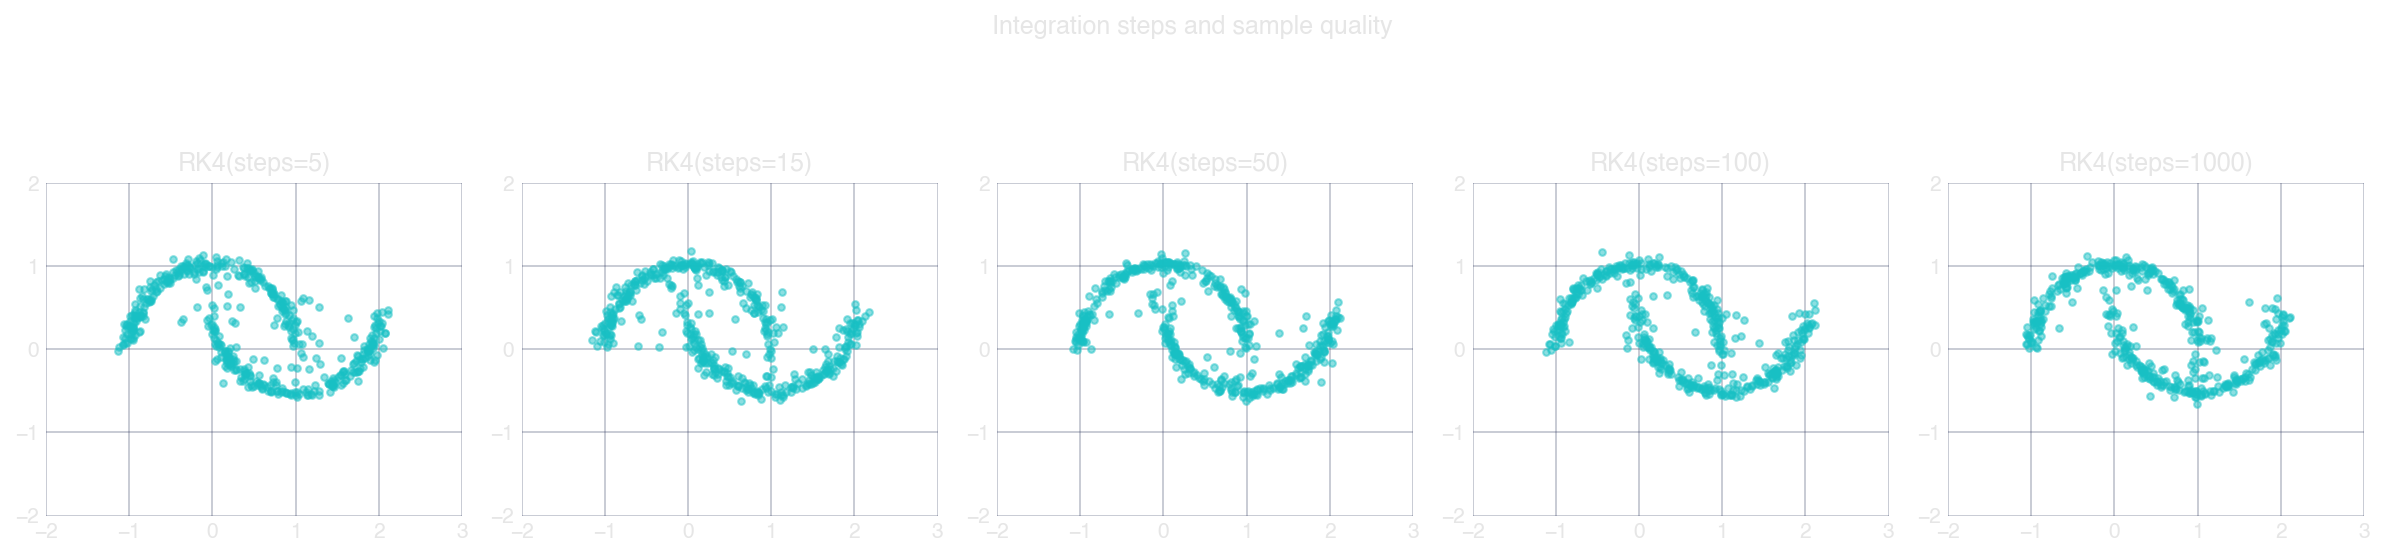

In [24]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

for ax, n_steps in zip(axes, [5, 15, 50, 100, 1000]):
    solver = nami.RK4(steps=n_steps)
    fm_temp = nami.FlowMatching(field=field, base=base, solver=solver)
    process_temp = fm_temp(None)
    
    with torch.no_grad():
        samples_temp = process_temp.sample((500,)).cpu()
    
    ax.scatter(samples_temp[:, 0], samples_temp[:, 1], alpha=0.5, s=10)
    ax.set_title(f'RK4(steps={n_steps})')
    ax.set_xlim(-2, 3)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.suptitle('Integration steps and sample quality', y=1.02)
plt.tight_layout()
util._show_fig(fig)

### Diagnostics

Nami provides (a small set for now) diagnostic tools to help validate trained models.

In [20]:
from nami import diagnostics

x_test = data[:100].to(device)
t_test = torch.rand(100, device=device)

# field statistics: are the velocity magnitudes reasonable?
stats = diagnostics.field_stats(field, x_test, t_test)
print("Velocity field statistics:")
print(f"  Mean norm: {stats['mean'].item():.3f}")
print(f"  Std norm:  {stats['std'].item():.3f}")
print(f"  Min norm:  {stats['min'].item():.3f}")
print(f"  Max norm:  {stats['max'].item():.3f}")

Velocity field statistics:
  Mean norm: 0.720
  Std norm:  0.383
  Min norm:  0.122
  Max norm:  2.219


Looking at the velocity field statistics from the diagnostic output these are quite reasonable. The moderate mean magnitude (0.720) suggests the network is learning meaningful velocities without being too aggressive or too passive. The average particle moves about 0.72 units per time step, which is reasonable for interpolation between distributions.The reasonable standard deviation (0.383) shows the spread around the mean is healthy, e.g. about half the mean value, indicating some variation in velocities but not extreme instability. A non-zero minimum (0.122) means all particles are moving. A minimum of exactly zero could indicate "stuck particles". The bound at (2.219) shows the maximum velocity is about 3x the mean, which suggests the field isn't producing extremely large, unstable velocities that could cause integration issues.

In [21]:
# reversibility error: how well does the flow invert?
# A good flow should return to the starting point when integrated forward then backward
rev_error = diagnostics.reversibility_error(
    field=field,
    solver=nami.RK4(steps=50),
    x=x_test,
    t0=1.0,
    t1=0.0,
)

print("\nReversibility error:")
print(f"  Mean: {rev_error['mean'].item():.2e}")
print(f"  Max:  {rev_error['max'].item():.2e}")


Reversibility error:
  Mean: 1.06e-07
  Max:  3.87e-07


### Shape conventions

Understanding nami's shape conventions is important when working with higher-dimensional data. The shape of a Tensor is sample_shape + batch_shape + event_shape, where:

- sample_shape: independent samples (from .sample(sample_shape))
- batch_shape: parallel computations (from context or data)
- event_shape: one data point (defined by event_ndim)

An example for image data:
```python
# image data: (batch, channels, height, width)
event_ndim = 3  # (C, H, W) forms one image

# after sampling with sample_shape=(16,) and batch_shape=(4,):
# Result: (16, 4, C, H, W)
#          ^   ^  ^^^^^^^  
#          |   |  event_shape
#          |   batch_shape  
#          sample_shape
```

### Fourier Feature Encodings

Neural networks with standard activations can struggle to learn high-frequency functions from low-dimensional inputs. Fourier features map inputs through sinusoids, enabling the network to capture sharp details. This technique comes from the NeRF paper and is particularly useful for Low-dimensional data (2D, 3D coordinates), problems requiring sharp boundaries and flow matching on complex distributions.

The mapping is:
$$\gamma(x) = [\sin(2\pi B x), \cos(2\pi B x)]$$

Where $B$ is a matrix of frequencies (random or learned).

---
## Summary

In this tutorial, we looked over how flow matching learns a velocity field $v(x, t)$ that transports noise to data. The training uses the simple MSE loss between predicted and target velocities, and sampling integrates the ODE from $t=1$ (noise) to $t=0$ (data). Diffusion models use a fixed forward process and learn to reverse it. Conditional generation binds context to guide the generation. Likelihood can be computed via the change-of-variables formula.


The originals:
- Lipman, Y., Chen, R. T. Q., Ben-Hamu, H., Nickel, M., & Le, M. (2023). *Flow Matching for Generative Modeling*. arXiv:2210.02747.
- Ho, J., Jain, A., & Abbeel, P. (2020). *Denoising Diffusion Probabilistic Models*. arXiv:2006.11239.